In [70]:
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sys
import operator
import argparse
import pickle
%matplotlib inline
df1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


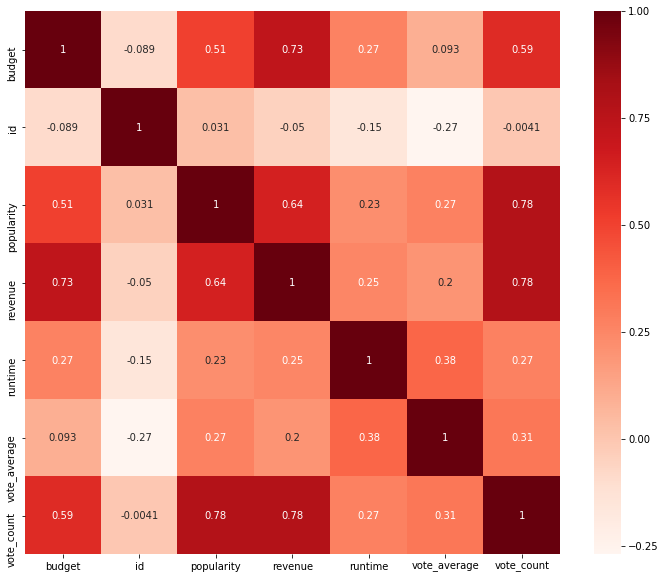

In [71]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [72]:
#Correlation with output variable
cor_target = abs(cor["popularity"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

budget        0.505414
popularity    1.000000
revenue       0.644724
vote_count    0.778130
Name: popularity, dtype: float64

**Demographic Filtering**
Using weighted rating 
(v/v+m)*R + (m/v+m)*C
where,

v is the number of votes for the movie;
m is the minimum votes required to be listed in the chart;
R is the average rating of the movie; And
C is the mean vote across the whole report

We already have v(vote_count) and R (vote_average) and C can be calculated as

In [73]:
C= df2['vote_average'].mean()
C

6.092171559442011

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [74]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

Now, we can filter out the movies that qualify for the chart

In [75]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

We see that there are 481 movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [76]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

define a new feature score, and calculate it based on weighted_rating

In [77]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [78]:
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)
pickle.dump(q_movies, open("/notebook/flask_app/popular10.pkl", "wb"))
q_movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew,score
1881,25000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",NaN,278,"[{""id"": 378, ""name"": ""prison""}, {""id"": 417, ""n...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,136.747729,"[{""name"": ""Castle Rock Entertainment"", ""id"": 97}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-23,28341469,142.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,8.5,8205,The Shawshank Redemption,"[{""cast_id"": 3, ""character"": ""Andy Dufresne"", ...","[{""credit_id"": ""52fe4231c3a36847f800b153"", ""de...",8.059258
662,63000000,"[{""id"": 18, ""name"": ""Drama""}]",http://www.foxmovies.com/movies/fight-club,550,"[{""id"": 825, ""name"": ""support group""}, {""id"": ...",en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,146.757391,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",1999-10-15,100853753,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Mischief. Mayhem. Soap.,Fight Club,8.3,9413,Fight Club,"[{""cast_id"": 4, ""character"": ""The Narrator"", ""...","[{""credit_id"": ""55731b8192514111610027d7"", ""de...",7.939256
65,185000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",http://thedarkknight.warnerbros.com/dvdsite/,155,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2008-07-16,1004558444,152.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Why So Serious?,The Dark Knight,8.2,12002,The Dark Knight,"[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de...",7.920020
3232,8000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 80, ""n...",NaN,680,"[{""id"": 396, ""name"": ""transporter""}, {""id"": 14...",en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",121.463076,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-10-08,213928762,154.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Just because you are a character doesn't mean ...,Pulp Fiction,8.3,8428,Pulp Fiction,"[{""cast_id"": 2, ""character"": ""Vincent Vega"", ""...","[{""credit_id"": ""52fe4269c3a36847f801caa3"", ""de...",7.904645
96,160000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://inceptionmovie.warnerbros.com/,27205,"[{""id"": 1014, ""name"": ""loss of lover""}, {""id"":...",en,Inception,"Cobb, a skilled thief who commits corporate es...",167.583710,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2010-07-14,825532764,148.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Your mind is the scene of the crime.,Inception,8.1,13752,Inception,"[{""cast_id"": 1, ""character"": ""Dom Cobb"", ""cred...","[{""credit_id"": ""56e8462cc3a368408400354c"", ""de...",7.863239
3337,6000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",http://www.thegodfather.com/,238,"[{""id"": 131, ""name"": ""italy""}, {""id"": 699, ""na...",en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",143.659698,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1972-03-14,245066411,175.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,An offer you can't refuse.,The

Text(0.5,1,'Popular Movies')

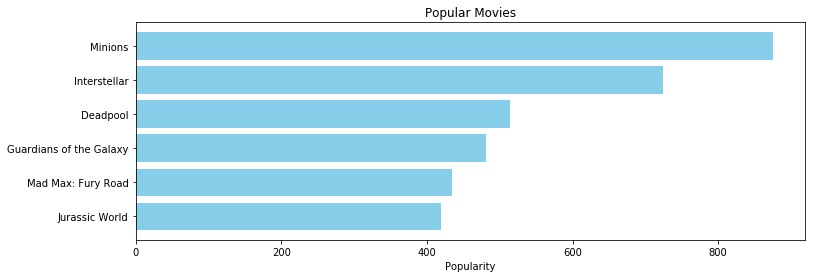

In [79]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

**Content based filtering**

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

to calculate simmilarity out of TF-IDF, we will use sklearn cosine,Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [81]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [82]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

Get the index of the movie given its title.
Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
Return the titles corresponding to the indices of the top elements.

In [83]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2.iloc[movie_indices]

In [90]:
darknight = get_recommendations('The Dark Knight Rises')
pickle.dump(darknight, open("/notebook/flask_app/darknight.pkl", "wb"))
print(darknight)

         budget                        ...                                                                       crew
65    185000000                        ...                          [{"credit_id": "55a0eb4a925141296b0010f8", "de...
299   100000000                        ...                          [{"credit_id": "52fe4241c3a36847f800fe1f", "de...
428    80000000                        ...                          [{"credit_id": "52fe423cc3a36847f800e513", "de...
1359   35000000                        ...                          [{"credit_id": "52fe422fc3a36847f800aa4b", "de...
3854    3500000                        ...                          [{"credit_id": "5612aa2ec3a368680b0159c9", "de...
119   150000000                        ...                          [{"credit_id": "52fe4230c3a36847f800ac6d", "de...
2507   15500000                        ...                          [{"credit_id": "564b3416c3a3686037003701", "de...
9     250000000                        ...              

In [91]:
superman = get_recommendations('Superman')
pickle.dump(superman, open("/notebook/flask_app/superman.pkl", "wb"))
superman

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
870,54000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,8536,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Superman II,Three escaped criminals from the planet Krypto...,30.515175,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1980-12-04,190458706,127.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Man of Steel meets his match!,Superman II,6.5,629,Superman II,"[{""cast_id"": 3, ""character"": ""Lex Luthor"", ""cr...","[{""credit_id"": ""52fe44aec3a36847f80a3f8d"", ""de..."
10,270000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://www.superman.com,1452,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Superman Returns,Superman returns to discover his 5-year absenc...,57.925623,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-06-28,391081192,154.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,NaN,Superman Returns,5.4,1400,Superman Returns,"[{""cast_id"": 3, ""character"": ""Superman / Clark...","[{""credit_id"": ""553bef6a9251416874003c8f"", ""de..."
2433,17000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",NaN,11411,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Superman IV: The Quest for Peace,With global superpowers engaged in an increasi...,17.062117,"[{""name"": ""Cannon Films"", ""id"": 4110}, {""name""...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1987-07-23,19300000,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"Nuclear Power. In the best hands, it is danger...",Superman IV: The Quest for Peace,4.1,318,Superman IV: The Quest for Peace,"[{""cast_id"": 19, ""character"": ""Superman / Clar...","[{""credit_id"": ""52fe443a9251416c7502d511"", ""de..."
914,50000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 35, ""nam...",http://www.centralintelligencemovie.com/,302699,"[{""id"": 470, ""name"": ""spy""}, {""id"": 591, ""name...",en,Central Intelligence,After he reunites with an old pal through Face...,45.318703,"[{""name"": ""New Line Cinema"", ""id"": 12}, {""name...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016-06-15,216972543,107.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Saving the world takes a little Hart and a big...,Central Intelligence,6.2,1650,Central Intelligence,"[{""cast_id"": 0, ""character"": ""Bob Stone"", ""cre...","[{""credit_id"": ""5863be259251412b8400cc12"", ""de..."
4659,0,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 18, ""...",NaN,306667,"[{""id"": 2673, ""name"": ""horse""}, {""id"": 10809, ...",en,Horse Camp,What’s the matter with Kathy (Jordan Trovillio...,0.172299,"[{""name"": ""Be Your Own Hollywood"", ""id"": 39706}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-01-10,0,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The summer they'll never forget,Horse Camp,5.5,2,Horse Camp,"[{""cast_id"": 2, ""character"": ""Kathy"", ""credit_...","[{""credit_id"": ""547880c3c3a36849bd000980"", ""de..."
2527,15000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 12, ""nam...",NaN,11153,"[{""id"": 279, ""name"": ""usa""}, {""id"": 5493, ""nam...",en,National Lampoon's Vacation,Clark Griswold is on a quest to take his famil...,22.838834,"[{""name"": ""Warner Bros."", ""id"": 6194}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1983-07-28,61399552,98.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Every summer Chevy Chase takes his family on a...,National Lampoon's Vacation,7.1,410,National Lampoon's Vacation,"[{""cast_id"": 1, ""ch

In [92]:
avatar = get_recommendations('Avatar')
pickle.dump(avatar, open("/notebook/flask_app/avatar.pkl", "wb"))
avatar

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
3604,5000000,"[{""id"": 27, ""name"": ""Horror""}, {""id"": 53, ""nam...",http://apollo18movie.net/,50357,"[{""id"": 305, ""name"": ""moon""}, {""id"": 1432, ""na...",en,Apollo 18,"Officially, Apollo 17 was the last manned miss...",17.028252,"[{""name"": ""Bazelevs Production"", ""id"": 1038}, ...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2011-07-20,25562924,86.0,"[{""iso_639_1"": ""cs"", ""name"": ""\u010cesk\u00fd""...",Released,There's a reason we've never gone back to the ...,Apollo 18,5.0,356,Apollo 18,"[{""cast_id"": 14, ""character"": ""Lt. Col. John G...","[{""credit_id"": ""53970554c3a3686415005ba8"", ""de..."
2130,20000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",http://focusfeatures.com/film/the_american/,27579,"[{""id"": 549, ""name"": ""prostitute""}, {""id"": 119...",en,The American,Dispatched to a small Italian town to await fu...,18.632156,"[{""name"": ""This Is That Productions"", ""id"": 10...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2010-08-31,65464324,104.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,NaN,The American,5.8,481,The American,"[{""cast_id"": 2, ""character"": ""Jack / Edward"", ...","[{""credit_id"": ""52fe4555c3a368484e0542fb"", ""de..."
634,63000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",http://www.warnerbros.com/matrix,603,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,The Matrix,"Set in the 22nd century, The Matrix tells the ...",104.309993,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",1999-03-30,463517383,136.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Welcome to the Real World.,The Matrix,7.9,8907,The Matrix,"[{""cast_id"": 34, ""character"": ""Thomas \""Neo\"" ...","[{""credit_id"": ""5831cc6d92514162d2027340"", ""de..."
1341,36500000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 14, ""nam...",http://oostrov.ru,16911,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",ru,Obitaemyy Ostrov,"On the threshold of 22nd century, furrowing th...",2.785832,"[{""name"": ""Art Pictures Studio"", ""id"": 3451}, ...","[{""iso_3166_1"": ""RU"", ""name"": ""Russia""}]",2008-12-18,21834845,115.0,"[{""iso_639_1"": ""ru"", ""name"": ""P\u0443\u0441\u0...",Released,NaN,The Inhabited Island,5.3,23,The Inhabited Island,"[{""cast_id"": 1, ""character"": ""Maxim Kammerer"",...","[{""credit_id"": ""54e46c62c3a368454b00a240"", ""de..."
529,70000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 18, ""nam...",NaN,9567,"[{""id"": 4595, ""name"": ""u.s. army""}, {""id"": 758...",en,Tears of the Sun,Navy SEAL Lieutenant A.K. Waters and his elite...,27.055085,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2003-03-07,85632458,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,He was trained to follow orders. He became a h...,Tears of the Sun,6.4,573,Tears of the Sun,"[{""cast_id"": 9, ""character"": ""Lieutenant A.K. ...","[{""credit_id"": ""537a1cd2c3a3681cdf000020"", ""de..."
1610,30000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://hannathemovie.com/,50456,"[{""id"": 782, ""name"": ""assassin""}, {""id"": 1430,...",en,Hanna,A 16-year-old girl raised by her father to be ...,31.191975,"[{""name"": ""Focus Features"", ""id"": 10146}, {""na...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",2011-04-07,63782078,111.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Adapt or die.,Hanna,6.5,1263,Hanna,"[{""cast_id"": 6, ""character"": ""Hanna Heller"", ""...","[{""credit_id"": ""52fe47c8c3a36847f8147ecb"", ""de..."
311,1000000

In this recommendations it's only based on the movie title, next we will inhance it to caputer more features.

In [93]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [94]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [95]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [96]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [97]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [98]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [99]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [100]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [104]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [105]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [106]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

,level_0,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew,director,soup
65,65,65,185000000,"[drama, action, crime]",http://thedarkknight.warnerbros.com/dvdsite/,155,"[dccomics, crimefighter, secretidentity]",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2008-07-16,1004558444,152.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Why So Serious?,The Dark Knight,8.2,12002,The Dark Knight,"[christianbale, heathledger, aaroneckhart]","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...",christophernolan,dccomics crimefighter secretidentity christian...
119,119,119,150000000,"[action, crime, drama]",http://www2.warnerbros.com/batmanbegins/index....,272,"[himalaya, martialarts, dccomics]",en,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded...",115.040024,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2005-06-10,374218673,140.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Evil fears the knight.,Batman Begins,7.5,7359,Batman Begins,"[christianbale, michaelcaine, liamneeson]","[{'credit_id': '52fe4230c3a36847f800ac6d', 'de...",christophernolan,himalaya martialarts dccomics christianbale mi...
4638,4638,4638,300000,"[drama, action, crime]",NaN,378237,[],en,Amidst the Devil's Wings,"Prequel to ""5th of a Degree.""",0.018087,"[{""name"": ""Daniel Columbie Films & Productions...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2014-12-01,0,90.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Prequel to ""5th of a Degree.""",Amidst the Devil's Wings,0.0,0,Amidst the Devil's Wings,[],[],,drama action crime
1196,1196,1196,40000000,"[drama, mystery, thriller]",http://wwws.warnerbros.de/theprestige/,1124,"[competition, secret, obsession]",en,The Prestige,A mysterious story of two magicians whose inte...,74.440708,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-10-19,109676311,130.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Are You Watching Closely?,The Prestige,8.0,4391,The Prestige,"[hughjackman, christianbale, michaelcaine]","[{'credit_id': '52fe42e8c3a36847f802beed', 'de...",christophernolan,competition secret obsession hughjackman chris...
3073,3073,3073,11500000,"[action, crime, drama]",NaN,2088,"[policeoperation, sexaddiction, police]",en,Romeo Is Bleeding,A corrupt cop gets in over his head when he tr...,4.850402,"[{""name"": ""Working Title Films"", ""id"": 10163},...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1993-09-13,3275585,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The story of a cop who wanted it bad and got i...,Romeo Is Bleeding,5.7,36,Romeo Is Bleeding,"[garyoldman, lenaolin, annabellasciorra]","[{'credit_id': '52fe4334c3a36847f80422ef', 'de...",petermedak,policeoperation sexaddiction police garyoldman...
3326,3326,3326,12500000,"[drama, action, crime]",NaN,312113,[],en,Black November,"A volatile, oil-rich Nigerian community wages ...",1.589693,"[{""name"": ""Wells & Jeta Entertainment"", ""id"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-12-07,0,95.0,[],Released,Blood Will Be Spilled,Black November,6.4,4,Black November,"[razaaqadoti, sarahwaynecallies, mickeyrourke]","[{'credit_id': '54911553c3a368465e000bca', 'de...",jetaamata,razaaqadoti sarahwaynecallies mickeyrourke je...
1503,1503,1503,32000000,"[action, crime, drama]",http://www.whoarethetakers.com/,22907,[heist],en,Takers,"A seasoned team of bank robbers, including Gor...",18.472420,"[{""name"": ""Rainforest Films""

We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

**Collaborative Filtering**

Now enough said , let's see how to implement this. Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the Surprise library to implement SVD.

In [107]:
from surprise import Reader, Dataset, SVD, evaluate
reader = Reader()
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.columns = ['userId', 'id', 'rating','timestamp']
ratings.head()

,userId,id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Merging the two datasets together, based on the movie id

In [108]:
ratings = ratings.merge(df2,on='id')

**Collaborative filtering model ** (User,Items)

After loading the dataset, we should look at the content of each file (users, ratings, items).

In [109]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# pass in column names for each CSV as the column name is not given in the file and read them using pandas.
# You can check the column names from the readme file

#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')

#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item', sep='|', names=i_cols,
encoding='latin-1')

In [110]:
print(users.shape)
users.head()

(943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [111]:
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [112]:
print(items.shape)
items.head()

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


The dataset has already been divided into train and test by GroupLens where the test data has 10 ratings for each user, i.e. 9,430 rows in total. We will read both these files into our Python environment.

In [113]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_train = pd.read_csv('../input/movielens-100k-dataset/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('../input/movielens-100k-dataset/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')
ratings_train.shape, ratings_test.shape

((90570, 4), (9430, 4))

**Building Model**

Recommending movies based on items, and users

In [114]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]

Building user-item matrix for calculating the similarity, using Cosine distance

In [115]:
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]
    # Calculating similarity
    from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(data_matrix, metric='cosine')
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')

Using item-item, user-user arrays, we will build our recommendation engine

In [116]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

Similarity between the users, and items

In [117]:
user_prediction = predict(data_matrix, user_similarity, type='user')
item_prediction = predict(data_matrix, item_similarity, type='item')
print(user_prediction)

[[ 2.06532606  0.73430275  0.62992381 ...  0.39359041  0.39304874
   0.3927712 ]
 [ 1.76308836  0.38404019  0.19617889 ... -0.08837789 -0.0869183
  -0.08671183]
 [ 1.79590398  0.32904733  0.15882885 ... -0.13699223 -0.13496852
  -0.13476488]
 ...
 [ 1.59151513  0.27526889  0.10219534 ... -0.16735162 -0.16657451
  -0.16641377]
 [ 1.81036267  0.40479877  0.27545013 ... -0.00907358 -0.00846587
  -0.00804858]
 [ 1.8384313   0.47964837  0.38496292 ...  0.14686675  0.14629808
   0.14641455]]


In [118]:
print(item_prediction)

[[0.44627765 0.475473   0.50593755 ... 0.58815455 0.5731069  0.56669645]
 [0.10854432 0.13295661 0.12558851 ... 0.13445801 0.13657587 0.13711081]
 [0.08568497 0.09169006 0.08764343 ... 0.08465892 0.08976784 0.09084451]
 ...
 [0.03230047 0.0450241  0.04292449 ... 0.05302764 0.0519099  0.05228033]
 [0.15777917 0.17409459 0.18900003 ... 0.19979296 0.19739388 0.20003117]
 [0.24767207 0.24489212 0.28263031 ... 0.34410424 0.33051406 0.33102478]]


# Predicting using surprise and SVD

In [119]:
from surprise import Reader, Dataset, SVD, evaluate
reader = Reader()
data = Dataset.load_from_df(ratings_train[['user_id', 'movie_id', 'rating']], reader)

In [120]:
from surprise import Reader, Dataset, SVD, evaluate
data.split(n_folds=5)
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/opt/conda/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/opt/conda/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9389
MAE:  0.7402
------------
Fold 2
RMSE: 0.9344
MAE:  0.7374
------------
Fold 3
RMSE: 0.9380
MAE:  0.7398
------------
Fold 4
RMSE: 0.9412
MAE:  0.7400
------------
Fold 5
RMSE: 0.9311
MAE:  0.7339
------------
------------
Mean RMSE: 0.9367
Mean MAE : 0.7383
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.938901668657558,
                             0.9343900958657236,
                             0.9379835967165683,
                             0.941169079239843,
                             0.9311493857299459],
                            'mae': [0.7401897410262759,
                             0.7374252596405486,
                             0.7398342862041377,
                             0.7399595678092643,
                             0.7339266581284941]})

RMSE = 0.93, which is more than good to have. And now predicting with SVD,
For the first try we are giving the prediction method a user ID with a movie ID that was never watched by this user, so basically the rating would be 0, and the estimated rating is actually pretty cool if this user decided to watch this movie.

In [121]:
 svd.predict(1, 500, 0)

Prediction(uid=1, iid=500, r_ui=0, est=3.9738962174215287, details={'was_impossible': False})

And in the second try, with a known data.

In [122]:
svd.predict(50, 15, 2)

Prediction(uid=50, iid=15, r_ui=2, est=3.157987221960729, details={'was_impossible': False})

# # Now lets get back some movie recommendations using Hybrid approach

In [123]:
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate
md = pd. read_csv('../input/the-movies-dataset/movies_metadata.csv')
md.head()
links_small = pd.read_csv('../input/the-movies-dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
md = md.drop([19730, 29503, 35587])
#Check EDA Notebook for how and why I got these indices.
md['id'] = md['id'].astype('int')
smd = md[md['id'].isin(links_small)]
smd.shape
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarn

In [124]:
id_map = pd.read_csv('../input/the-movies-dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [125]:
indices_map = id_map.set_index('id')

In [126]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [127]:
u1diehard = hybrid(1, 'Die Hard')
pickle.dump(u1diehard, open("/notebook/flask_app/u1_diehard.pkl", "wb"))
u1diehard

,title,vote_count,vote_average,id,est
144,Die Hard: With a Vengeance,2094.0,6.9,1572,4.401746
467,Romeo Is Bleeding,36.0,5.7,2088,4.042781
414,Hot Shots! Part Deux,463.0,6.2,9255,3.860156
1120,Under Siege,405.0,6.1,8845,3.667712
1106,Die Hard 2,1920.0,6.6,1573,3.648162
344,True Lies,1138.0,6.8,36955,3.553779
4929,Passenger 57,264.0,5.6,10538,3.515412
3200,Code of Silence,44.0,6.0,20721,3.515412
8036,Sound of Noise,38.0,7.6,48392,3.515412
6228,The Anderson Tapes,40.0,6.4,30941,3.515412


In [128]:
u101avatar = hybrid(101, 'Avatar')
pickle.dump(u101avatar, open("/notebook/flask_app/u101_avatar.pkl", "wb"))
u101avatar

,title,vote_count,vote_average,id,est
538,Hellraiser: Bloodline,111.0,4.9,8766,3.795621
975,A Grand Day Out,199.0,7.4,530,3.235587
2059,The Matrix,9079.0,7.9,603,3.181090
5229,Ambush,13.0,6.3,49320,3.181090
1437,Species II,161.0,4.5,10216,3.181090
4643,"Heaven Knows, Mr. Allison",27.0,6.8,37103,3.181090
4328,Dog Soldiers,227.0,6.7,11880,3.181090
6882,Semi-Pro,255.0,5.4,13260,3.181090
2854,The Hidden,85.0,6.7,12476,3.181090
7763,Hanna,1284.0,6.5,50456,3.181090


In [129]:
u200spartacus = hybrid(200, 'Spartacus')
pickle.dump(u200spartacus, open("/notebook/flask_app/u200_spartacus.pkl", "wb"))
u200spartacus

,title,vote_count,vote_average,id,est
268,Quiz Show,262.0,7.1,11450,4.539815
2520,Three Ages,20.0,7.2,32628,4.008041
7764,American: The Bill Hicks Story,20.0,8.0,46105,4.008041
5531,Revengers Tragedy,2.0,3.8,23750,4.008041
4622,Intervista,11.0,5.6,47715,4.008041
4145,My Wife Is an Actress,9.0,6.3,14651,4.008041
7549,Empire of Dreams: The Story of the Star Wars T...,22.0,7.1,76180,4.008041
1817,History of the World: Part I,205.0,6.5,10156,4.008041
2647,City Lights,444.0,8.2,901,4.008041
6105,A Trip to the Moon,314.0,7.9,775,4.008041


Applying AutoML:

In [ ]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(ratings_train[['user_id','movie_id']],ratings_train['rating'], train_size=0.75, test_size=0.25)

pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5, random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)
print(pipeline_optimizer.score(X_test, y_test))

Using pickle to export the model to executable package for API deployment.  
The flask app will be accessed via port 5000.

In [130]:
import pickle
#pickle.dump(q_movies, open("/notebook/flask_app/recommendations_system.pkl", "wb"))
#mrs_model = pickle.load(open("/notebook/flask_app/recommendations_system.pkl", "rb"))
#mrs_model
# The model saved as popular10.pkl
mrs_model = pickle.load(open("/notebook/flask_app/popular10.pkl", "rb"))
mrs_model

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew,score
1881,25000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",NaN,278,"[{""id"": 378, ""name"": ""prison""}, {""id"": 417, ""n...",en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,136.747729,"[{""name"": ""Castle Rock Entertainment"", ""id"": 97}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-09-23,28341469,142.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,8.5,8205,The Shawshank Redemption,"[{""cast_id"": 3, ""character"": ""Andy Dufresne"", ...","[{""credit_id"": ""52fe4231c3a36847f800b153"", ""de...",8.059258
662,63000000,"[{""id"": 18, ""name"": ""Drama""}]",http://www.foxmovies.com/movies/fight-club,550,"[{""id"": 825, ""name"": ""support group""}, {""id"": ...",en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,146.757391,"[{""name"": ""Regency Enterprises"", ""id"": 508}, {...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",1999-10-15,100853753,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Mischief. Mayhem. Soap.,Fight Club,8.3,9413,Fight Club,"[{""cast_id"": 4, ""character"": ""The Narrator"", ""...","[{""credit_id"": ""55731b8192514111610027d7"", ""de...",7.939256
65,185000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",http://thedarkknight.warnerbros.com/dvdsite/,155,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight,Batman raises the stakes in his war on crime. ...,187.322927,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2008-07-16,1004558444,152.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Why So Serious?,The Dark Knight,8.2,12002,The Dark Knight,"[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de...",7.920020
3232,8000000,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 80, ""n...",NaN,680,"[{""id"": 396, ""name"": ""transporter""}, {""id"": 14...",en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",121.463076,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1994-10-08,213928762,154.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Just because you are a character doesn't mean ...,Pulp Fiction,8.3,8428,Pulp Fiction,"[{""cast_id"": 2, ""character"": ""Vincent Vega"", ""...","[{""credit_id"": ""52fe4269c3a36847f801caa3"", ""de...",7.904645
96,160000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",http://inceptionmovie.warnerbros.com/,27205,"[{""id"": 1014, ""name"": ""loss of lover""}, {""id"":...",en,Inception,"Cobb, a skilled thief who commits corporate es...",167.583710,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2010-07-14,825532764,148.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Your mind is the scene of the crime.,Inception,8.1,13752,Inception,"[{""cast_id"": 1, ""character"": ""Dom Cobb"", ""cred...","[{""credit_id"": ""56e8462cc3a368408400354c"", ""de...",7.863239
3337,6000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 80, ""name...",http://www.thegodfather.com/,238,"[{""id"": 131, ""name"": ""italy""}, {""id"": 699, ""na...",en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",143.659698,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1972-03-14,245066411,175.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,An offer you can't refuse.,The